# Bayesian Gaussian Mixture Models

**COMP9418-17s2, W04 Tutorial**

- Instructor: Edwin V. Bonilla
- School of Computer Science and Engineering, UNSW Sydney
- Questions by Daniel Mackinlay and Edwin V. Bonilla


In this tutorial we will explore the Bayesian version of the Gaussian Mixture model and its use of expectation maximisation to update parameters.
A variational Bayesian Gaussian mixture model is implemented in `scikit-learn` as 
[BayesianGaussianMixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html)
This is very similar to the non-Bayesian case, except we can supply prior distributions for all the parameters.
We will explore different priors settings and see their effect on the inferred parameters, and also observe the variational optimisation steps involved in convergence in this model.

Our data set will be the classic [Old Faithful dataset](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat). This is mentioned in many places, including Bishop's textbook, and you can read about it there.



## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run these commands:

```python
pip install scikit-learn seaborn pandas
```




Once we have done all that, we
import some useful modules for later use.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn

# Put the graphs where we can see them
%matplotlib inline
# make them prettier
sns.set(style="ticks")
# make them bigger
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

# easier debugging display
np.set_printoptions(edgeitems=5, precision=3, suppress=False)


# Data loading


In [2]:
with open('faithful.dat') as handle:
    # The first 25 lines are text, which we print out but don't use
    for i in range(25):
        print(handle.readline(), end="")
    #  The next part of the file we read using `pandas`
    data = pd.read_csv(handle, delim_whitespace=True)


Old Faithful Geyser Data

Description: (From R manual):

     Waiting time between eruptions and the duration of the eruption
     for the Old Faithful geyser in Yellowstone National Park, Wyoming,
     USA.

     A data frame with 272 observations on 2 variables.

eruptions  numeric  Eruption time in mins
waiting    numeric  Waiting time to next eruption

References:

     Hardle, W. (1991) Smoothing Techniques with Implementation in S.
     New York: Springer.

     Azzalini, A. and Bowman, A. W. (1990). A look at some data on the
     Old Faithful geyser. Applied Statistics 39, 357-365.







We'll print the data to see what it looks like

In [3]:
data.head(20)

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
6,2.883,55
7,4.700,88
8,3.600,85
9,1.950,51
10,4.350,85


It's also useful to notice that `pandas` gives us some simple summary statistics with a one-liner:

In [4]:
data.describe()

,eruptions,waiting
count,272.000000,272.000000
mean,3.487783,70.897059
std,1.141371,13.594974
min,1.600000,43.000000
25%,2.162750,58.000000
50%,4.000000,76.000000
75%,4.454250,82.000000
max,5.100000,96.000000


## Exercise
Plot the data. How many clusters do you observe? How many mixture components do you think will be optimal for this model?

In [5]:
# Your code here

# Basic Model learning


The `BayesianGaussianMixture` class has a similar API to the `GaussianMixture` class from the last tutorial, but it has more parameters.
We will initialise our model with explicit non-default values for many these parameters to have more control over the  parameters.

You should know by now how to read the [online documentation](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) for this class and be aware that you can get help for API for a given class or method by using jupyter's built-in help function. Just type in, e.g.
```
BayesianGaussianMixture?
```
This should give you an idea of what all the constructor arguments mean.
There are many arguments, and we will be using most of them, so it would be a good idea for you to actually read the manual at this point if you have not already done so.

At this step the most important thing to notice is that we will not be using the default component weight prior, the Dirichlet process, which we have not yet covered in lectures. Instead, we will use the basic Dirichlet distribution, which we have discussed extensively. This is specified in the `weight_concentration_prior_type` argument.

We will be interested in seeing how different values for the prior distribution affect our inference, through the `weight_concentration_prior` argument.

You should remember the various important methods of the Gaussian mixture model, which are standard across `scikit-learn`.
Start by constructing a basic `BayesianGaussianMixture` object and fitting the data, using a mixture with 10 components:

In [6]:
from sklearn.mixture import BayesianGaussianMixture

mixture_model = BayesianGaussianMixture(
    n_components=10,
    random_state=5,  # control the pseudo-random initialization
    weight_concentration_prior_type='dirichlet_distribution',
    weight_concentration_prior=1.0,  # parameter of the Dirichlet component prior
    max_iter=200,  # choose this to be big in case it takes a long time to fit
)
mixture_model.fit(data);


## Exercise

How many parameters does a Dirichlet distribution have for a 10-category model? How many parameters does the `weight_concentration_prior` argument to this model accept with `n_components`=10? Why are these parameter vectors different sizes?

# Component weight prior

First, we will modify two useful functions from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/mixture/plot_concentration_prior.html), which automate the process of drawing ellipses to visualise 
the mixture components. You should familiarize yourself with what these functions do - what does the opacity of an ellipse represent?

In [7]:
import matplotlib.gridspec as gridspec

def plot_ellipses(ax, weights, means, covars):
    """
    Given a list of mixture component weights, means, and covariances,
    plot ellipses to show the orientation and scale of the Gaussian mixture dispersal.
    """
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1],
            180 + angle,
            edgecolor=None,)
        ell2 = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1],
            180 + angle,
            edgecolor='black',
            fill=False,
            linewidth=1,)
        ell.set_clip_box(ax.bbox)
        ell2.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)
        ax.add_artist(ell2)

        
def plot_results(model, x, y, title, plot_title=False):
    fig, ax = plt.subplots(3, 1, sharex=False)
    gs = gridspec.GridSpec(3, 1)
    
    ax1 = plt.subplot(gs[0:2, 0])
    ax1.set_title(title)
    ax1.scatter(x, y, s=5, marker='o', alpha=0.8)
    ax1.set_xticks(())
    ax1.set_yticks(())
    n_components = model.get_params()['n_components']
    plot_ellipses(ax1, model.weights_, model.means_,
                  model.covariances_)

    ax2 = plt.subplot(gs[2, 0])
    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(model.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left='off',
                    right='off', labelleft='off')
    ax2.tick_params(axis='x', which='both', top='off')

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')


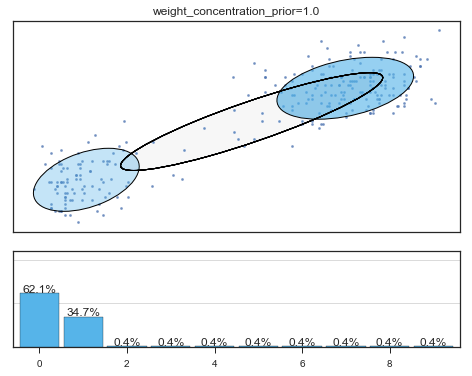

In [8]:
plot_results(
    mixture_model,
    data['eruptions'], data['waiting'],
    'weight_concentration_prior={}'.format(1.0))

## Exercise

Plot the inferred mixture components for `weight_concentration_prior` values of $(0.1, 1.0, 10.0, 100.0)$. What difference does this make to the inferred model?
(If you want to start a new plot, use `plt.figure()`)

In [9]:
# Your code here

# Gaussian component priors

## Exercise
Read the documentation for the model constructor argument `covariance_prior`.
The default value is data-dependent - what value does it take for this data set?


In [10]:
# Your code here

## Exercise
Try fitting the model with different values of the `covariance_prior`. Use *spherical* covariance, where all terms on the diagonal are the same and all off-diagonal terms are zero. How does this change our model fit? Why is the effect different on the `eruptions` and `waiting` axes?

Tip: if you want an identity matrix, the command `np.eye` will produce it for you.

In [11]:
# Your code here

## Exercise
Next, read the documentation for the `mean_prior` and `mean_precision_prior`.
Try different values of the `mean_precision_prior` with `mean_prior=(2.0, 50.0)`.
How many means does this model use? Why do we specify only one mean prior value?

In [12]:
# Your code here

# Expectation maximisation steps

By default, the `BayesianGaussianMixture` fitting procedure continues until “convergence”, when the fit is “good enough”.
If we are interested in knowing more about the model fit we can use the `verbose` argument to the model constructor, which will print some debug messages.

However, we can get still more details by examining each individual step of the procedure by setting the model to only do one EM step at a time, by using the arguments `max_iter` and `warm_start`, which, respectively, restrict the number of EM steps and allow us to continue fitting the model.


## Exercise

Fit the model again with your choice of priors. However, this time, record the values of the lower bound (the `lower_bound_` member on the mixture model object) and plot their convergence. Plot the model fit for several different stages of the convergence.

*Tip 1*: The member `converged_` tells you whether a model has converged or not.

*Tip 2*: Don't plot every step of the model fit, or you will have too many graphs to easily display.

In [14]:
lower_bounds = []
mixture_model = BayesianGaussianMixture(
    n_components=10,
    covariance_type='full',
    max_iter=1,
    random_state=2,
    weight_concentration_prior_type='dirichlet_distribution',
    warm_start=True,
)
for i in range(200):
    # Your code here

IndentationError: expected an indented block (<ipython-input-14-6616b71974f3>, line 11)

## Exercise

How sensitive is this convergence to the initialization we chose for the model? Plot several lower bound curves for 5 different random initialisations and compare.


In [ ]:
# Your code here